# Create model
 Load data <br>
 Performs hiperparameter search <br>
 Train model with predefined hyperparameters <br>
 Evaluate model with Train/Validation dataset <br>
 Evaluate model with Test dataset
 

## Load libraries 
Install & load python libraries

In [2]:
pip install tabgan==1.3.3 #9500 secs

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install lightgbm

In [4]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [5]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load data 
Load train & test data from parquet file previously saved <br>
Define limpiar_nombres_columnas & nombres_de_columnas <br>
Define input variables for model <br>
Define is do hyperparameter search or not

In [7]:
hp_search = 1 #whether search hyperparameters or run directly 

s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
df1Train = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Train/Train.parquet")
tg1Train = df1Train['target']

df1Val = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Validation/Validation.parquet")
tg1Val = df1Val['target']


In [8]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
df1Train = limpiar_nombres_columnas(df1Train)
df1Val = limpiar_nombres_columnas(df1Val)

In [9]:
#List of columns from dataframe
def nombres_de_columnas(dataframe):
    return dataframe.columns.tolist()

# Supongamos que tu DataFrame se llama 'df'
# Puedes ajustar el nombre según el que hayas utilizado

nombres_columnas = nombres_de_columnas(df1Train)

# Imprimir los nombres de las columnas
print(f'Nombres de columnas: {nombres_columnas}')


Nombres de columnas: ['id_branch', 'id_receiver', 'date_receiver', 'id_location', 'id_payer', 'id_sender_global', 'net_amount_receiver', 'receiver_transaction_count', 'id_country_receiver_claim', 'id_state_receiver_claim', 'id_state', 'branch_working_days', 'sender_sending_days', 'sender_days_to_last_transaction', 'id_country', 'fraud_classification', 'sender_minutes_since_last_transaction', 'branch_minutes_since_last_transaction', 'sender_days_since_last_transaction', 'branch_trans_3m', 'sender_state', 'branch_has_fraud', 'receiver_has_fraud', 'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 'location_nro_fraud', 'sender_trans_3m', 'range_hist', 'sender_nro_fraud', 'mes', 'hour_receiver', '01_isMexico', '01_sender_branch_state', '01_var_range_hist', '01_receiver_fraud', '01_branch_fraud', '01_location_fraud', '01_sender_fraud', '01_isCashPick', '01_isBankDep', 'sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365', 'sender_days_to_last_transa

In [10]:
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count','01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [11]:
#Load train & validation and join both for latter split
X_train = df1Train[var_input]
X_test = df1Val[var_input] 
y_train =  pd.DataFrame(df1Train['target']) 
y_test = pd.DataFrame(df1Val['target']) 

X = pd.concat([df1Train[var_input], df1Val[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 


In [12]:
def calcular_porcentaje_valor_1(columna):
    """
    Calcula el porcentaje de ocurrencia del valor 1 en una columna dicotómica.

    Parameters:
    - columna: Columna con valores binarios (0 o 1).

    Returns:
    - Porcentaje de ocurrencia del valor 1.
    """

    total_registros = len(columna)
    ocurrencias_valor_1 = columna.sum()

    porcentaje_valor_1 = (ocurrencias_valor_1 / total_registros) * 100

    return porcentaje_valor_1
porcentaje_1 = calcular_porcentaje_valor_1(Y['target'])
porcentaje_1

0.0021704207172218042

## Hyperparameter search/Modelo train

In [13]:
# Split into train (80%) and validation (20%)
# X_train: features for train, X_test: features for validation
# y_train: labels for train, y_test: labels for validation

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 88) 

In [14]:
fit_parameters = {
    #"early_stopping_rounds": 30,           # Number of rounds to stop train when there is no more improvement
    "eval_metric": 'logloss',              # Metric for evaluation
    "eval_set": [(X_test, y_test)],        # Dataset for evaluation during training
    'eval_names': ['valid'],               # Name for validation set
    #'verbose': 100,                        # Log level of output during training
}

In [15]:
# Parameters for hiperparamenter search (RandomizedSearchCV)
param_testeo = {
    "n_estimators": [5, 10, 15, 20, 25, 30, 35, 50, 100, 150, 300, 400, 500, 510, 520],
    # Number of estimatores (trees) to fit

    "num_leaves": [2, 3, 4, 6, 10, 20, 25, 28, 30, 31, 32, 33, 35, 40, 45],
    # Maximun number of node leaves

    "max_depth": [10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 35, 100, 125, 150, 170, 200, 250, 300, 400],
    # Maximun tree depth

    "colsample_bytree": [0.50, 0.55, 0.6, 0.65, 0.68, 0.70, 0.71, 0.80, 0.81, 0.84, 0.85, 0.86, 0.9],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [0.001, 0.002, 0.0025, 0.0026, 0.0027, 0.003, 0.004, 0.005, 0.007, 0.008, 0.009],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.1, 0.02, 0.03, 0.04, 0.07, 0.005, 0.003, 0.001],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [16]:
# Parameters for hiperparamenter search (RandomizedSearchCV) restricted to the first result obtained
param_testeoB = {
    "n_estimators": [460, 480, 400,  500, 510, 520, 530],
    # Number of estimatores (trees) to fit

    "num_leaves": [ 25, 26, 28, 30, 32, 34, 35],
    # Maximun number of node leaves

    "max_depth": [ 17, 18, 19, 20, 21, 22, 23],
    # Maximun tree depth

    "colsample_bytree": [ 0.82 ,0.83, 0.84, 0.86, 0.87],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [ 0.0025, 0.0026, 0.0027, 0.0031, 0.0033 ],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [17]:
# This parameter defines the number of hiperparameters points to be tested
n_HP_points_to_test = 100


In [18]:
def entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87):
    """
    Trains model using LightGBM with RandomizedSearchCV for hyperparameters

    Parameters:
    - X: Input features of dataset.
    - Y: Labels of dataset.
    - fit_parameters: Parameters for model training and testing.
    - param_testeo: Parameters for random hyperparameter seacrh.
    - n_HP_points_to_test: Number of hiperparameters points to be tested (predetermined: 100).
    - random_state: Random seed for reproducibility (predetermined: 87).

    Returns:
    - Object with RandomizedSearchCV results.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    # Clean column names calling function limpiar_nombres_columnas
    X_train = limpiar_nombres_columnas(X_train)
    X_test = limpiar_nombres_columnas(X_test)

    # Create clasifier LightGBM and perform parametric search of hyperparameters
    lgbm = LGBMClassifier(random_state=random_state)
    result_trainRandom = RandomizedSearchCV(
                        estimator=lgbm, 
                        param_distributions=param_testeo, 
                        n_iter=n_HP_points_to_test,
                        scoring='f1_micro',
                        cv=3,
                        refit=True,
                        random_state=random_state,
                        verbose=True)

    # Train model using train data and parampeters
    result_trainRandom.fit(X_train, y_train.values.ravel(), **fit_parameters)

    return result_trainRandom
   


In [19]:
#If hp_search == 1 it does hyperparameter search 
if hp_search == 1:
    result = entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves O

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves O

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves O

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves O

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves O

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves O

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919740
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 188, number of negative: 8919741
[LightGBM] [Info] Total Bins 2690
[LightGBM] [Info] Number of data points in the train set: 8919929, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.767336
[LightGBM] [Info] Start training from score -10.767336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 189, number of negative: 8919741
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 8919930, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.762030
[LightGBM] [Info] Start training from score -10.762030


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 283, number of negative: 13379611
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 13379894, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000021 -> initscore=-10.763796
[LightGBM] [Info] Start training from score -10.763796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [20]:
if hp_search == 1:
    result.best_params_

In [21]:
# Train model with best hyperparameters found in search
if hp_search == 1:
    lgb_classifier = LGBMClassifier(**result.best_params_)

In [22]:
# Set parameters for model from result of previuos hyperparameter search
if hp_search == 0:
    best_params_ = {'subsample': 1,
     'scale_pos_weight': 0.003,
     'objective': 'binary',
     'num_leaves': 30,
     'n_estimators': 520,
     'min_child_weight': 0.0026,
     'max_depth': 20,
     'learning_rate': 0.07,
     'importance_type': 'gini',
     'colsample_bytree': 0.84,
     'boosting_type': 'gbdt'}

    lgb_classifier = LGBMClassifier(**best_params_)

In [23]:
# Fit model to data
import lightgbm as lgb
train_data  = lgb.Dataset(X_train, label = y_train)
#model = lgb.train(params, train_data, num_boost_round=5)

lgb_classifier.fit(np.array(X_train), y_train)
lbg_predictions_labels = lgb_classifier.predict(X_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 299, number of negative: 13379595
[LightGBM] [Info] Total Bins 2679
[LightGBM] [Info] Number of data points in the train set: 13379894, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000022 -> initscore=-10.708798
[LightGBM] [Info] Start training from score -10.708798


# Evaluate model on train/validation data

In [24]:
# Predict using trained model 
data1_f_data_pred_rf = lgb_classifier.predict(X)

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = lgb_classifier.predict_proba(X)

# Extract puntuations (probabilites) for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Create a copy ot the labels for further analysis
Y_c = Y.copy()
Y_c = pd.DataFrame(Y_c)

# Set prediction and puntuationsof model for positive labels
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

# Y_c dataframe can be used for further analysis
#Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 

In [25]:
 Y_c[Y_c['target'] == True]

,target,preds_rf,score_rf
18834,True,True,0.986055
29264,True,False,0.001819
124527,True,False,0.040207
357990,True,True,0.701642
392994,True,True,0.726897
...,...,...,...
16337912,True,False,0.000017
16338876,True,False,0.127735
16359004,True,True,0.866818
16552447,True,True,0.896296


In [26]:
# Model threshold for positive class
Y_c.score_rf[Y_c['preds_rf']==True].min()

0.5012995012333263

In [27]:
# Validate total of each class
Y_c['preds_rf'].value_counts()

preds_rf
False    16724562
True          306
Name: count, dtype: int64

In [28]:
# Confusion matriz for predefined thershold 
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,16724504,1
1,58,305


<Axes: xlabel='score_rf', ylabel='Count'>

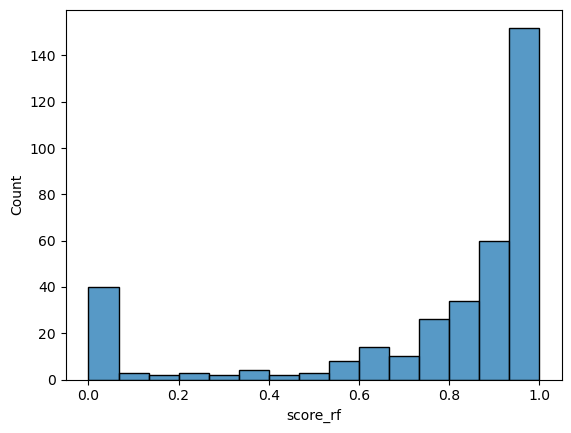

In [29]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [30]:
target_names = ['No fraude', 'Fraude']
print(classification_report(Y_c['target'], Y_c['preds_rf'], target_names=target_names))

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00  16724505
      Fraude       1.00      0.84      0.91       363

    accuracy                           1.00  16724868
   macro avg       1.00      0.92      0.96  16724868
weighted avg       1.00      1.00      1.00  16724868



In [31]:
# Divide into tiles and compute cature al 0.04% for train/validation dataset
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')

percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURE .04%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURE .04%:
0.9889807162534435


In [32]:
# Table with totals by n-tile
DECILES_T = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES_T

target,False,True
FRAUD_DECILE,,
1,16368,357
2,16724,1
3,16724,1
4,16725,0
5,16725,0
...,...,...
996,16725,0
997,16725,0
998,16725,0


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

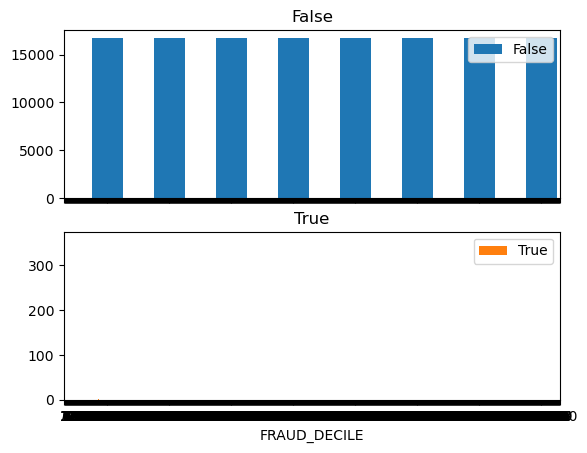

In [33]:
# Plot class by n-tile
DECILES_T.plot.bar(stacked=False, rot=0,subplots=True)

In [34]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             4.213351e-07  9.999695e-01
2             1.258815e-07  4.212761e-07
3             6.222481e-08  1.258812e-07
4             3.751846e-08  6.222470e-08
5             2.539750e-08  3.751823e-08
...                    ...           ...
996           8.699459e-14  9.878377e-14
997           7.399187e-14  8.699285e-14
998           5.957560e-14  7.398897e-14
999           4.160842e-14  5.957457e-14
1000          8.303463e-16  4.160765e-14

[1000 rows x 2 columns]

In [35]:
#Get thresold for .03% of data with highest score
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()

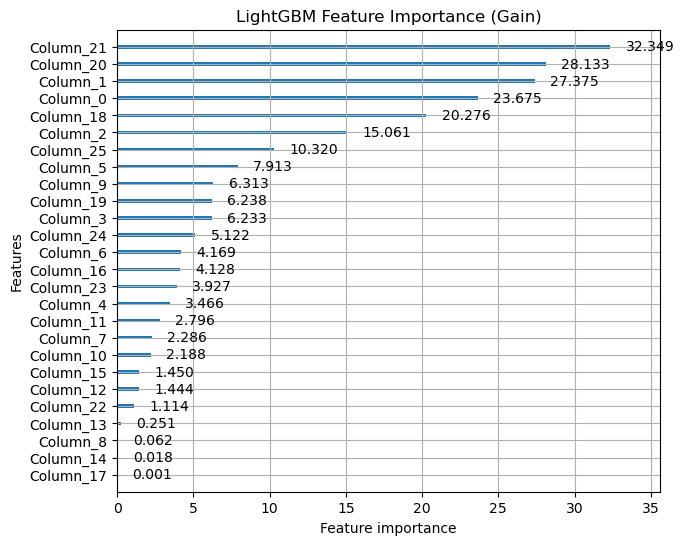

In [36]:
# Plot feature importance using Gain
lgb.plot_importance(lgb_classifier, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

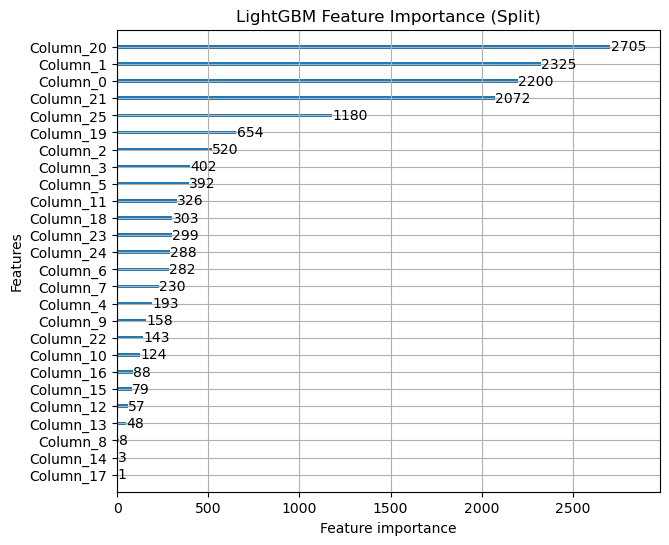

In [37]:
# Plot feature importance using Split
lgb.plot_importance(lgb_classifier, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [38]:
# Run when it has to save new model
import joblib
joblib.dump(lgb_classifier, 'ModeloFinalLimpio.pkl')
with open("./ModeloFinalLimpio.txt", "w") as output:
    output.write(str(var_input))


In [39]:
# Save thresholds to recode score
pd.options.display.float_format = "{:,.20f}".format
Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
Buckets = Buckets.reset_index()
Buckets['final_score'] = 1-(Buckets['FRAUD_DECILE']/1000)
Buckets.to_csv ('./BucketsModeloFinalLimpio.csv')

In [40]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
#np.savetxt('./ModeloFinal_sin_rtcImp.txt', lgb_classifier.booster_.feature_importance(importance_type='gain'),fmt='%f')

## Evaluate model on test data ##

In [41]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
tes = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Test/Test.parquet")

In [42]:
## Variable list for input
X = tes[var_input]
Y = tes['target'] 
testeo = tes

In [43]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo = limpiar_nombres_columnas(testeo)

In [44]:
print ("Dataset Length: ", len(testeo)) 
print ("Dataset Shape: ", testeo.shape)

Dataset Length:  9416156
Dataset Shape:  (9416156, 77)


In [45]:
testeo['target'].value_counts(dropna=False)

target
False    9416072
True          84
Name: count, dtype: int64

In [46]:
## Variables of model
X_TESTEO = tes[var_input]
X_TESTEO

,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,"2,548.00000000000000000000",288.00000000000000000000,0,1,1,0,0,1.00000000000000000000,0,True,True,1.00000000000000000000,False,False,False,False,True,0,0.00000000000000000000,NaN,0.27804796243501594954,0.12635379061371840304,0.00000000000000000000,NaN,NaN,0.62500000000000000000
1,7.00000000000000000000,17.00000000000000000000,0,9,3,3,0,2.00000000000000000000,0,True,True,0.95999999999999996447,False,False,False,True,False,0,0.00000000000000000000,0.00000000000000000000,0.01609927888646654412,0.43321299638989169134,0.00243055555555555559,0.00000000000000000000,0.00000000000000000000,0.79166666666666662966
2,3.00000000000000000000,"2,118.00000000000000000000",0,4,2,3,0,8.00000000000000000000,0,True,True,0.80952380952380953438,False,False,False,True,False,0,0.04950495049504950729,0.25000000000000000000,0.14187489518698642721,0.04296028880866425981,0.00104166666666666665,0.00000000000000000000,0.00000000000000000000,0.62500000000000000000
3,70.00000000000000000000,"3,453.00000000000000000000",0,1,1,0,0,8.00000000000000000000,0,False,True,1.12820512820512819374,False,False,False,False,True,0,0.23762376237623761277,1.00000000000000000000,0.49069260439376155558,0.04368231046931408262,0.00000000000000000000,0.01643835616438356004,0.02857142857142857054,0.83333333333333337034
4,2.00000000000000000000,"3,632.00000000000000000000",0,5,3,3,0,5.00000000000000000000,0,False,True,0.34013605442176869653,False,False,False,True,False,0,0.00990099009900990111,0.34821428571428569843,0.04913634076806976114,0.03610108303249097428,0.00000000000000000000,0.03835616438356164587,0.06666666666666666574,0.58333333333333337034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9416151,15.00000000000000000000,"3,694.00000000000000000000",0,4,1,2,0,7.00000000000000000000,0,False,True,0.87788054554005323649,False,False,False,True,False,0,0.00000000000000000000,1.00000000000000000000,0.29548884789535467821,0.28880866425992779423,0.00000000000000000000,0.03835616438356164587,0.06666666666666666574,0.75000000000000000000
9416152,5.00000000000000000000,"3,560.00000000000000000000",0,2,2,0,0,2.00000000000000000000,0,True,True,1.00000000000000000000,False,False,False,False,True,0,0.00000000000000000000,1.00000000000000000000,0.35753815193694449270,0.03249097472924187407,0.00000000000000000000,0.08219178082191780366,0.14285714285714284921,0.62500000000000000000
9416153,38.00000000000000000000,"3,194.00000000000000000000",1,2,1,2,1,4.00000000000000000000,0,True,True,0.54545454545454541417,True,True,False,True,False,0,0.00000000000000000000,0.27321428571428568732,0.38789200067080326084,0.10830324909747292284,0.00000000000000000000,0.06027397260273972823,0.10476190476190476442,0.54166666666666662966
9416154,24.00000000000000000000,729.00000000000000000000,3,2,1,0,3,2.00000000000000000000,0,True,True,0.48437500000000000000,True,True,False,False,True,0,0.00000000000000000000,0.48749999999999998890,0.16065738722119737858,0.11191335740072201610,0.00000000000000000000,0.07397260273972602884,0.12857142857142855874,0.83333333333333337034


In [47]:
# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO = pd.DataFrame(testeo['target'])

# Predict test using trained model
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO)

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = lgb_classifier.predict_proba(X_TESTEO)

# Extract puntuations (probabilites) for positive class
# Assumes that second column has probabilites for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [48]:
# Create a copy DataFrame 'Y_TESTEO' to preserve original data
Y_TESTEO_c = Y_TESTEO.copy()

# Set prediction and puntuationsof model for positive labels
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf
Y_TESTEO_c['score_rf'] = score_rf

# Get classification
Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte

In [49]:
# Confusion matriz for predefined thershold 
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['preds_rf']))

,0,1
0,9416071,1
1,82,2


In [50]:
# Confusion matriz for selected thershold 
Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['pred_corte']))

,0,1
0,9384211,31861
1,25,59


In [51]:
# Divide into tiles and compute cature al 0.04% for train/validation dataset
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=10, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}

percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['FRAUD_DECILE'] = np.nan
Y_TESTEO_c['FRAUD_DECILE'] = percentiles
Y_TESTEO_c['FRAUD_DECILE'] = Y_TESTEO_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURE .04%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_TESTEO_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURE .04%:
1.0


In [52]:
DECILES = pd.crosstab(Y_TESTEO_c['FRAUD_DECILE'], Y_TESTEO_c['target'])

In [53]:
DECILES

target,False,True
FRAUD_DECILE,,
1,941537,79
2,941615,0
3,941611,5
4,941615,0
5,941616,0
6,941615,0
7,941616,0
8,941615,0
9,941616,0


In [54]:
Y_TESTEO_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': ['min', 'max']}) 

score_rf                       
                                min                    max
FRAUD_DECILE                                              
1            0.00000000021576087058 0.99059356888854177559
2            0.00000000006360665717 0.00000000021576041323
3            0.00000000002926638182 0.00000000006360653268
4            0.00000000001594171834 0.00000000002926635013
5            0.00000000000938403752 0.00000000001594171644
6            0.00000000000569761504 0.00000000000938402815
7            0.00000000000343652448 0.00000000000569761497
8            0.00000000000195843908 0.00000000000343652384
9            0.00000000000093287347 0.00000000000195843891
10           0.00000000000000027446 0.00000000000093287322

array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

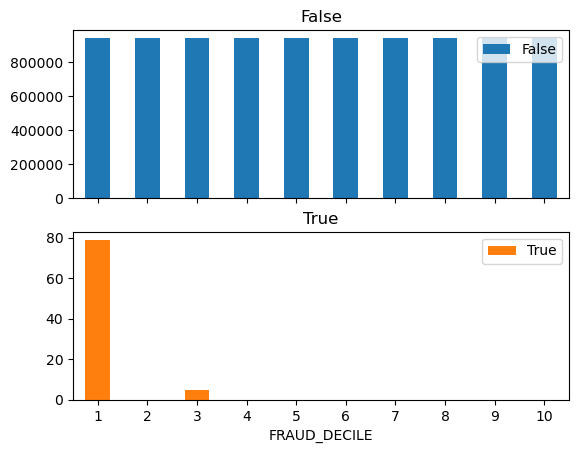

In [55]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)